In [1]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_permits = pd.read_csv('../data/tmp88fjt5pm.csv', low_memory=False)

In [3]:
df_permits = pd.read_csv('../data/tmp88fjt5pm.csv', low_memory=False)[['total_fees', 'city', 'declared_valuation', 'zip', 'permittypedescr', 'total_fees', 'worktype']]
df_prop_2024 = pd.read_csv('../data/property-assessment-data-2024.csv', low_memory=False)[['TOTAL_VALUE', 'MAIL_CITY', 'ZIP_CODE', 'BLDG_VALUE']]
df_prop_2009 = pd.read_csv('../data/property-assessment-data-2009.csv', low_memory=False)[['AV_TOTAL', 'MAIL CS', 'ZIPCODE', 'AV_BLDG']]

Take the data, with only a few metrics to look at: 'TOTAL_VALUE', 'MAIL_CITY', 'ZIP_CODE', 'BLDG_VALUE' for 2024 and 2009 data. 'total_fees', 'city', 'declared_valuation', 'zip', 'permittypedescr', 'total_fees', 'worktype' for the permits data. 

In [4]:
print(df_prop_2024.dtypes)
print(df_prop_2009.dtypes)
print(df_permits.dtypes)

TOTAL_VALUE     object
MAIL_CITY       object
ZIP_CODE       float64
BLDG_VALUE      object
dtype: object
AV_TOTAL      int64
MAIL CS      object
ZIPCODE     float64
AV_BLDG       int64
dtype: object
total_fees            object
city                  object
declared_valuation    object
zip                   object
permittypedescr       object
total_fees            object
worktype              object
dtype: object


## Process the data!

In [5]:
df_permits['declared_valuation'] = df_permits['declared_valuation'].str.replace(',', '').str.replace('$', '')
df_permits['total_fees'] = df_permits['total_fees'].astype(str)
df_permits['total_fees'] = df_permits['total_fees'].fillna('0')
df_permits['total_fees'] = df_permits['total_fees'].apply(lambda x: x.replace('$', '') if isinstance(x, str) else x)

df_prop_2024['TOTAL_VALUE'] = df_prop_2024['TOTAL_VALUE'].astype(str)
df_prop_2024['TOTAL_VALUE'] = df_prop_2024['TOTAL_VALUE'].str.replace(',', '')
df_prop_2024['TOTAL_VALUE'] = df_prop_2024['TOTAL_VALUE'].astype(float)
df_prop_2024['BLDG_VALUE'] = df_prop_2024['BLDG_VALUE'].astype(str)
df_prop_2024['BLDG_VALUE'] = df_prop_2024['BLDG_VALUE'].str.replace(',', '')
df_prop_2024['BLDG_VALUE'] = df_prop_2024['BLDG_VALUE'].astype(float)

df_prop_2009['AV_TOTAL'] = df_prop_2009['AV_TOTAL'].astype(float)

It's necessary to process the data beforehand, otherwise it will be hard to represent the data numerically; certain 'object' data types like total_fees are a bit tougher because commas and '$' symbols need to be removed first. Rows in total_fees which contained 0 values were removed as well, since these had an impact on the resulting data.

### ORGANIZED BY ZIP PERMIT DATA AND PREPROCESSING

In [6]:
# Drop rows with NaN values in 'zip' or zero values in declared valuation and remove any '-' from 'zip'
df_permits = df_permits.dropna(subset=['zip'])
df_permits['declared_valuation'] = df_permits['declared_valuation'].astype(float)
df_permits_filtered = df_permits[df_permits['declared_valuation'] != 0]

# Drop NaN values in both permittypedescr and worktype
df_permits_filtered = df_permits_filtered.dropna(subset=['permittypedescr'])
df_permits_filtered = df_permits_filtered.dropna(subset=['worktype'])
df_permits_filtered['zip'] = df_permits_filtered['zip'].apply(lambda x: str(x).split('-')[0] if '-' in str(x) else str(x))

# Convert 'zip' to float after cleaning
df_permits_filtered['zip'] = df_permits_filtered['zip'].astype(float)

# Convert 'declared_valuation' to float
df_permits_filtered['declared_valuation'] = df_permits_filtered['declared_valuation'].astype(float)

# Group by 'zip' and sum 'declared_valuation'
total_valuation_by_zip = df_permits_filtered.groupby('zip')['declared_valuation'].sum().reset_index()

# Save the result to a CSV file
total_valuation_by_zip.to_csv('./updated_extraction/total_valuation_by_zip.csv', index=False)

Preprocess the data further, and save to './updated_extraction/total_valuation_by_zip' to have access in the future. Most of this preprocessing relates to dropping 0 values and ensuring that the zip data is formatted in such a way where it can be reduced to its individual digits (02179-29012 should just be 02179).

### PRINT OUT THE PREPROCESSING RESULTS

In [44]:
# Print the first entries out
print(df_permits_filtered.head(10))
print(df_prop_2024.head(10))
print(df_prop_2009.head(10))

   total_fees           city  declared_valuation     zip  \
0     $390.00         Boston            36500.00  2109.0   
1      $29.00   West Roxbury            40000.00  2132.0   
2      $70.00    Charlestown             5000.00  2129.0   
3     $803.00        Roxbury            74295.75  2118.0   
4     $182.00       Brighton            15000.00  2135.0   
5      $33.00        Allston                1.00  2134.0   
6     $556.00        Allston            50000.00  2134.0   
9     $120.00  Jamaica Plain            10000.00  2130.0   
10     $30.00        Roxbury                1.00  2118.0   
11     $73.00    Charlestown             5000.00  2129.0   

             permittypedescr total_fees worktype  
0   Amendment to a Long Form    $390.00   INTEXT  
1   Amendment to a Long Form     $29.00      COB  
2   Amendment to a Long Form     $70.00    OTHER  
3   Amendment to a Long Form    $803.00   INTEXT  
4   Amendment to a Long Form    $182.00   EXTREN  
5   Amendment to a Long Form     

### ORGANIZED BY ZIP PROPERTY DATA 2024

In [8]:
average_valuation_by_zip_2024 = df_prop_2024.groupby('ZIP_CODE')['TOTAL_VALUE'].mean()
average_building_valuation_by_zip_2024 = df_prop_2024.groupby('ZIP_CODE')['BLDG_VALUE'].mean()

# Save the result directly to a CSV file
average_valuation_by_zip_2024.to_csv('./updated_extraction/avg_total_value_zip_2024.csv', index=True)
average_building_valuation_by_zip_2024.to_csv('./updated_extraction/avg_building_value_zip_2024.csv', index=True)

Save the organized property data of 2024 to its own csv. 

### ORGANIZED BY ZIP PROPERTY DATA 2009

In [9]:
average_valuation_by_zip_2009 = df_prop_2009.groupby('ZIPCODE')['AV_TOTAL'].mean()
average_building_valuation_by_zip_2009 = df_prop_2009.groupby('ZIPCODE')['AV_BLDG'].mean()

# Save the result directly to a CSV file
average_valuation_by_zip_2009.to_csv('./updated_extraction/avg_total_value_zip_2009.csv', index=True)
average_building_valuation_by_zip_2009.to_csv('./updated_extraction/avg_building_value_zip_2009.csv', index=True)

Save the organized property data of 2009 to its own csv.

### CALCULATE THE DELTA FOR EACH ZIP FOR TOTAL VALUE

In [24]:
import pandas as pd

# Load the CSV files into DataFrames
df_2009 = pd.read_csv('./updated_extraction/avg_total_value_zip_2009.csv')
df_2024 = pd.read_csv('./updated_extraction/avg_total_value_zip_2024.csv')

# Rename the columns to have a consistent name for merging
df_2009.rename(columns={'AV_TOTAL': 'VALUE', 'ZIPCODE': 'zip'}, inplace=True)
df_2024.rename(columns={'ZIP_CODE': 'zip', 'TOTAL_VALUE': 'VALUE'}, inplace=True)

# Merge the DataFrames on the ZIP_CODE column
merged_df = pd.merge(df_2009, df_2024, on='zip', how='inner')

print(merged_df.head(10))

# Calculate the change in value
merged_df['CHANGE_IN_VALUE'] = merged_df['VALUE_y'] - merged_df['VALUE_x']

# Create a new DataFrame with only the ZIP_CODE and CHANGE_IN_VALUE columns
change_in_value_df = merged_df[['zip', 'CHANGE_IN_VALUE']]

# Save the new DataFrame to a CSV file
change_in_value_df.to_csv('./updated_extraction/updated_change_in_value_2009_2024.csv', index=False)

print("The updated_change_in_value_2009_2024.csv file has been created successfully.")

      zip       VALUE_x       VALUE_y
0  2108.0  2.051241e+06  3.515321e+06
1  2109.0  2.575337e+06  3.917270e+06
2  2110.0  4.985515e+06  6.278642e+06
3  2111.0  2.176317e+06  3.257750e+06
4  2113.0  5.586605e+05  9.515368e+05
5  2114.0  1.782156e+06  3.102280e+06
6  2115.0  2.070738e+06  4.415471e+06
7  2116.0  1.818235e+06  3.098001e+06
8  2118.0  8.127465e+05  1.513732e+06
9  2119.0  4.106052e+05  9.125422e+05
The updated_change_in_value_2009_2024.csv file has been created successfully.


This code takes the differences seen in the value of properties by zip according to the 2009 to 2024 data. The rationale for taking 2009 as the starting point as opposed to years earlier is because of the earliest data in the building permits data (first documented peices were from 2009). Taking other years into consideration would be one way to extract further data: however, in this case, since this would be finding correlates that may not be in reference to the spending, I've chosen to take 2009 as the calculation for the initial when computing this delta. The code above takes a look at the TOTAL_VALUE, as opposed to the building value. The resulting value of this delta (average total value by zip in 2024 - average total value by zip in 2009) is placed in a csv called 'updated_change_in_value_2009_2024.csv'. 

### CALCULATE THE DELTA FOR EACH ZIP FOR BUILDING VALUE

In [25]:
import pandas as pd

# Load the CSV files into DataFrames
df_2009 = pd.read_csv('./updated_extraction/avg_building_value_zip_2009.csv')
df_2024 = pd.read_csv('./updated_extraction/avg_building_value_zip_2024.csv')

# Rename the columns to have a consistent name for merging
df_2009.rename(columns={'AV_BLDG': 'VALUE', 'ZIPCODE': 'zip'}, inplace=True)
df_2024.rename(columns={'ZIP_CODE': 'zip', 'BLDG_VALUE': 'VALUE'}, inplace=True)

# Merge the DataFrames on the ZIP_CODE column
merged_df = pd.merge(df_2009, df_2024, on='zip', how='inner')

print(merged_df.head(10))

# Calculate the change in value
merged_df['CHANGE_IN_VALUE'] = merged_df['VALUE_y'] - merged_df['VALUE_x']

# Create a new DataFrame with only the ZIP_CODE and CHANGE_IN_VALUE columns
change_in_value_df = merged_df[['zip', 'CHANGE_IN_VALUE']]

# Save the new DataFrame to a CSV file
change_in_value_df.to_csv('./updated_extraction/updated_building_change_in_value_2009_2024.csv', index=False)

print("The updated_change_in_value_2009_2024.csv file has been created successfully.")

      zip       VALUE_x       VALUE_y
0  2108.0  1.597950e+06  2.662840e+06
1  2109.0  2.031703e+06  2.952053e+06
2  2110.0  4.029240e+06  5.018508e+06
3  2111.0  1.853090e+06  2.587040e+06
4  2113.0  4.088251e+05  7.159002e+05
5  2114.0  1.359428e+06  2.423999e+06
6  2115.0  1.714669e+06  3.483042e+06
7  2116.0  1.468313e+06  2.494948e+06
8  2118.0  6.663215e+05  1.220007e+06
9  2119.0  2.953960e+05  6.393102e+05
The updated_change_in_value_2009_2024.csv file has been created successfully.


Similar to above, this data performs the same operation, however, it looks at the data in terms of building value appreciation. The reason for this investigation is two-fold: firstly, I wanted to see if these answers differed (if the final ratio would be different), and secondly, building value seems to document a more crucial change. This change is more correlated with spending since it does not factor the appreciation of the value of the land which may be purely based on demand changes and increases of influx in a city. 
The resulting value of this delta (average building value by zip in 2024 - average building value by zip in 2009) is placed in a csv called 'updated_building_change_in_value_2009_2024.csv'. 

### COMPARE DECLARED_VALUATION VS. CHANGE_IN_VALUE_2009_2024 FOR TOTAL VALUE

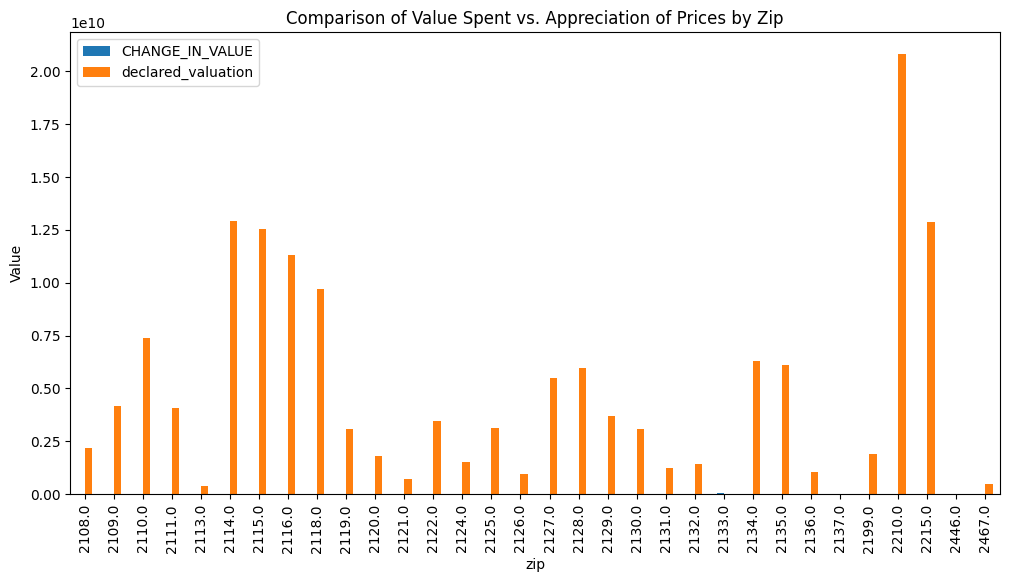

The updated_ratio_spent_by_zip.csv file has been created successfully.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files into DataFrames
df_change = pd.read_csv('./updated_extraction/updated_change_in_value_2009_2024.csv')
df_valuation = pd.read_csv('./updated_extraction/total_valuation_by_zip.csv')

df_change.rename(columns={'ZIP_CODE': 'zip'}, inplace=True)

# Merge the DataFrames on the 'zip' column
df_merged = pd.merge(df_change, df_valuation, on='zip', how='inner')

# Calculate the ratio of appreciation to valuation
df_merged['ratio'] = df_merged['CHANGE_IN_VALUE'] / df_merged['declared_valuation']

# Save the 'zip' and 'ratio' columns to a new CSV file
df_merged[['zip', 'ratio']].to_csv('./updated_extraction/updated_ratio_spent_by_zip.csv', index=False)

# Draw a bar chart to compare the value spent vs. appreciation of prices by each zip
df_merged.set_index('zip')[['CHANGE_IN_VALUE', 'declared_valuation']].plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Value Spent vs. Appreciation of Prices by Zip')
plt.ylabel('Value')
plt.show()

print("The updated_ratio_spent_by_zip.csv file has been created successfully.")

This code calculates the ratio of spending by each city and compares this against the observed appreciation of price. This will help to describe what may be best correlated to the appreciation: are spending, increased demand, or decreased supply the greatest correlates?

### COMPARE DECLARED_VALUATION VS. CHANGE_IN_VALUE_2009_2024 FOR BUILDING VALUE

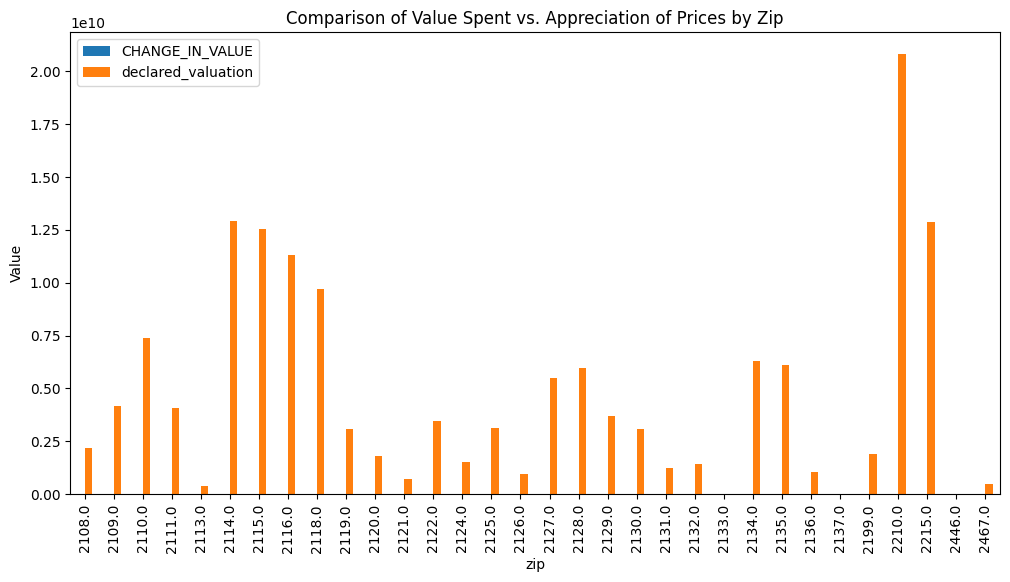

The updated_ratio_spent_by_zip.csv file has been created successfully.


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files into DataFrames
df_change = pd.read_csv('./updated_extraction/updated_building_change_in_value_2009_2024.csv')
df_valuation = pd.read_csv('./updated_extraction/total_valuation_by_zip.csv')

df_change.rename(columns={'ZIP_CODE': 'zip'}, inplace=True)

# Merge the DataFrames on the 'zip' column
df_merged = pd.merge(df_change, df_valuation, on='zip', how='inner')

# Calculate the ratio of appreciation to valuation
df_merged['ratio'] = df_merged['CHANGE_IN_VALUE'] / df_merged['declared_valuation']

# Save the 'zip' and 'ratio' columns to a new CSV file
df_merged[['zip', 'ratio']].to_csv('./updated_extraction/updated_building_ratio_spent_by_zip.csv', index=False)

# Draw a bar chart to compare the value spent vs. appreciation of prices by each zip
df_merged.set_index('zip')[['CHANGE_IN_VALUE', 'declared_valuation']].plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Value Spent vs. Appreciation of Prices by Zip')
plt.ylabel('Value')
plt.show()

print("The updated_ratio_spent_by_zip.csv file has been created successfully.")

This code and chart examine this ratio: value spent on building / appreciation of building value by zip.

### UPDATED RATIO WITHOUT OUTLIERS FOR TOTAL VALUE

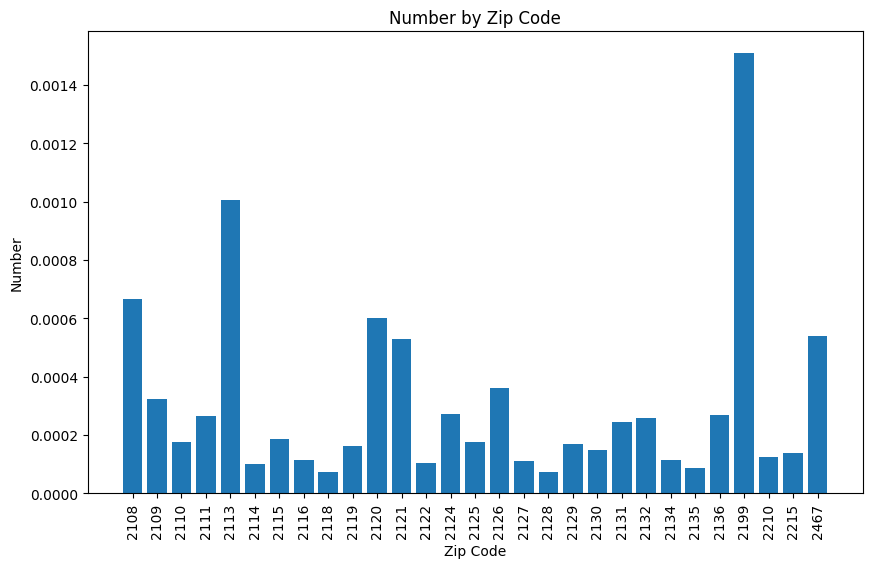

In [22]:
df = pd.read_excel("./updated_extraction/ratio_without_outliers/no_outlier_data_ratio.xlsx")

plt.figure(figsize=(10,6))  # Creates a new figure with a specified size
plt.bar(df['zip'].astype(str), df['ratio'])  # Creates a bar plot with zip codes on the x-axis and numbers on the y-axis
plt.xlabel('Zip Code')  # Labels the x-axis
plt.ylabel('Number')  # Labels the y-axis
plt.title('Number by Zip Code')  # Adds a title to the plot
plt.xticks(rotation=90)  # Rotates x-axis labels for better visibility
plt.show()

Remove the outliers for total_value (those which are above 1 in this ratio), since those outliers are a result of low spending ($7000 spending total yielding $10000 in appreciation, ex.).

### UPDATED RATIO WITHOUT OUTLIERS FOR BUILDING VALUE

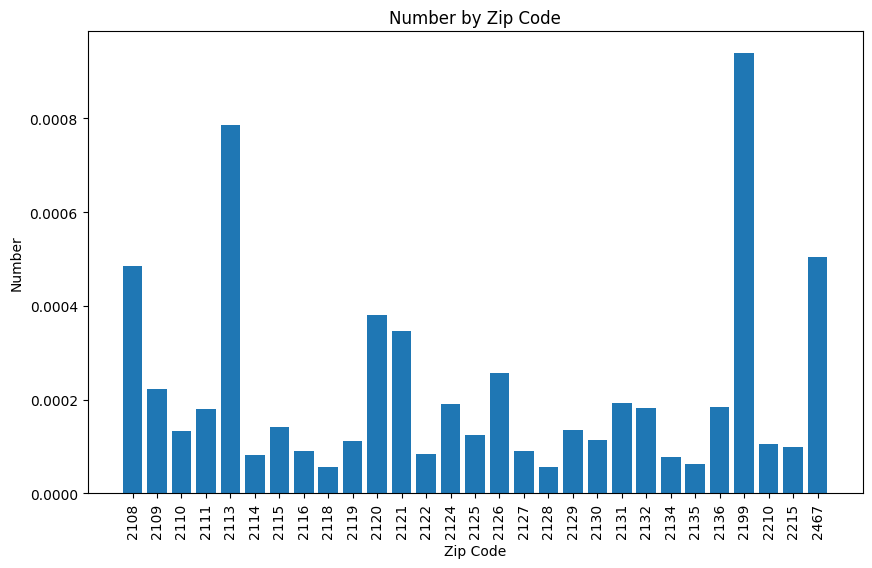

In [27]:
df = pd.read_excel("./updated_extraction/ratio_without_outliers/no_outlier_data_ratio_building.xlsx")

plt.figure(figsize=(10,6))  # Creates a new figure with a specified size
plt.bar(df['zip'].astype(str), df['ratio'])  # Creates a bar plot with zip codes on the x-axis and numbers on the y-axis
plt.xlabel('Zip Code')  # Labels the x-axis
plt.ylabel('Number')  # Labels the y-axis
plt.title('Number by Zip Code')  # Adds a title to the plot
plt.xticks(rotation=90)  # Rotates x-axis labels for better visibility
plt.show()

Same here, remove the outliers. 

### MAP THE ZIPS TO THEIR RESPECTIVE CITIES

In [38]:
df_ratio = pd.read_csv('ratio_spent_by_zip.csv')

df_permits = df_permits.dropna(subset=['zip', 'city'])

zip_to_city = df_permits.drop_duplicates('zip').set_index('zip')['city'].to_dict()

# Map the 'zip' in df_ratio to 'city' using the dictionary
df_ratio['city'] = df_ratio['zip'].map(zip_to_city)

# Drop the 'zip' column
df_ratio = df_ratio.drop(columns=['zip'])

df_ratio.to_csv('ratio_spent_by_city.csv', index=False)

Condensing this data back into their cities to make the data more readable. 

### PLOT THE RESULTS

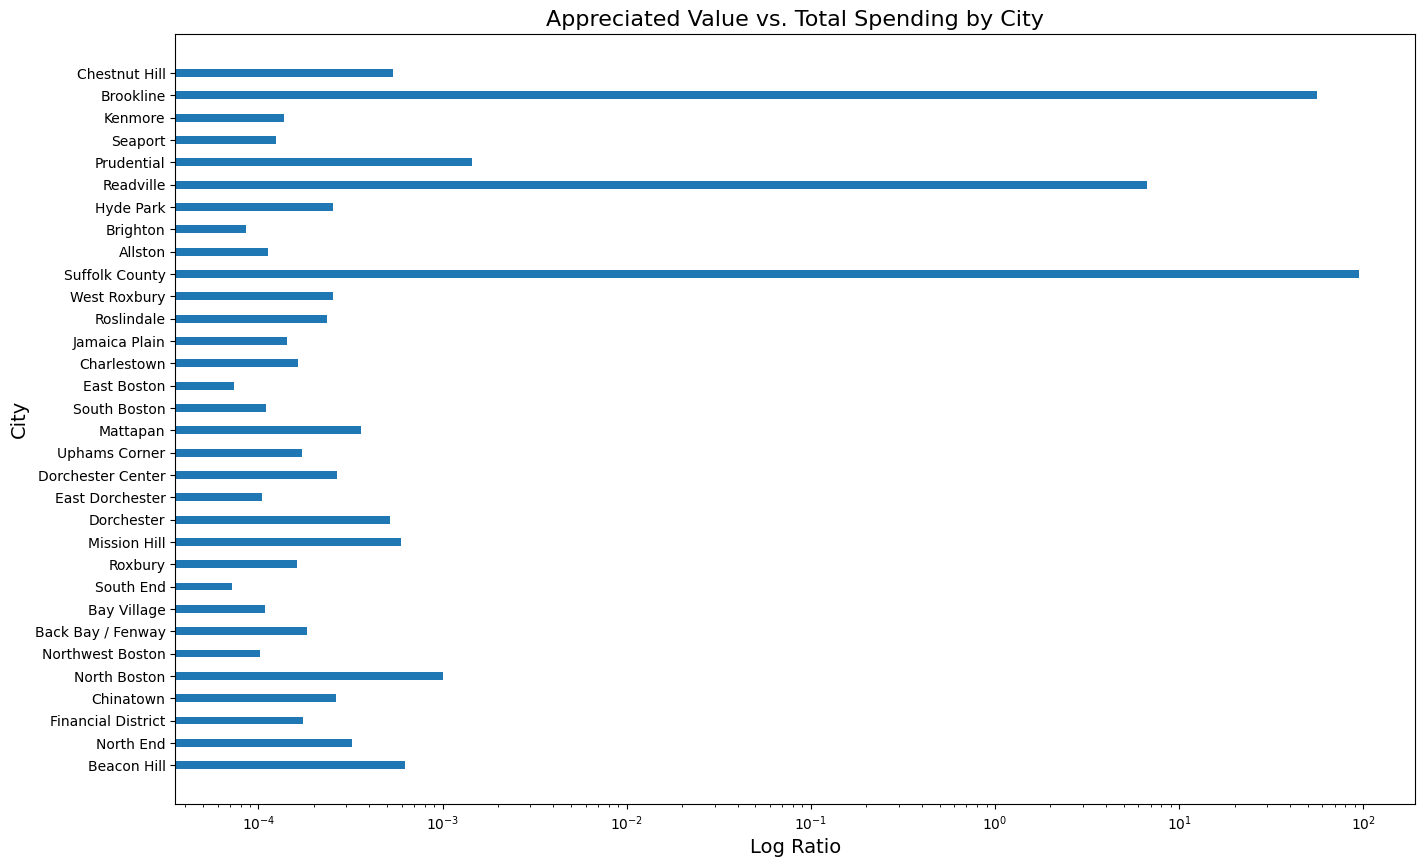

: 

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('./final data/ratio_spent_by_city_condensed.csv')

# Plot the data in a bar chart with a log-based y-axis
plt.figure(figsize=(16, 10))
plt.barh(df['City'], df['ratio'], height=.35)
plt.xscale('log')
plt.ylabel('City', fontsize=14)
plt.xlabel('Log Ratio', fontsize=14)
plt.title('Appreciated Value vs. Total Spending by City', fontsize=16)
plt.show()


In [42]:
# df = df.dropna(subset=['zip'])
# df['zip'] = df['zip'].astype(str)
# df['zip'] = df['zip'].str.zfill(5)
# df = df.sort_values(by=['zip'])
# df['zip'].value_counts().sort_index().plot(kind='bar')
df['city'] = df['city'].astype('category')

# Group by 'city' and sum 'declared_valuation'
cost_by_city = df.groupby('city')['declared_valuation'].sum().sort_values(ascending=False)

# Convert the grouped data to a dictionary
cost_dict = cost_by_city.to_dict()

unique_valuation_by_city.to_csv('unique_valuation_by_city.csv', index=False)

# plt.figure(figsize=(10, 6))
plt.bar(cost_dict.keys(), cost_dict.values())
plt.xlabel('Zip Code')
plt.xticks(rotation=90) 
plt.ylabel('Total Cost')
plt.title('Total Cost by Zip Code')
plt.savefig('filename.svg')
plt.show()

KeyError: 'city'

clean_city             object
declared_valuation    float64
dtype: object
      clean_city  declared_valuation
0                       4.317100e+04
1        allston        5.725940e+09
2           back        1.205627e+08
3       back bay        6.821400e+05
4         beacon        8.690000e+04
5    beacon hill        1.708011e+06
6         boston        9.264263e+10
7       brighton        7.130630e+09
8    charlestown        3.794869e+09
9   charleswtown        1.550000e+04
10      chestnut        2.020756e+07
11     chinatown        2.382446e+06
12    dorchester        9.522113e+09
13      downtown        1.253359e+08
14             e        5.000000e+03
15          east        6.018534e+09
16        fenway        1.403692e+08
17     financial        1.542875e+07
18          hyde        1.076020e+09
19       jamaica        3.259257e+09
20       kenmore        8.620000e+04
21      mattapan        8.676776e+08
22       mission        1.834582e+09
23         north        6.920000e+04
2

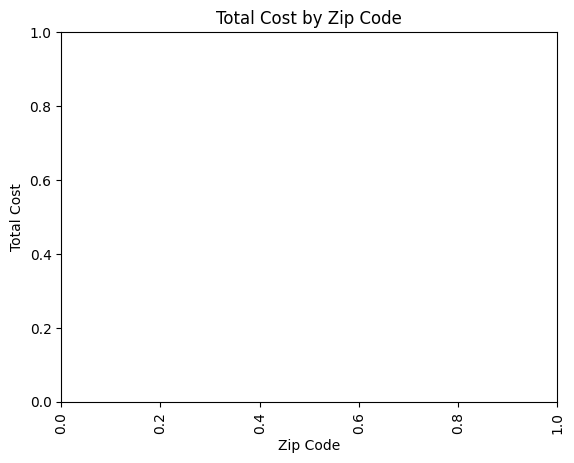

In [83]:
import pandas as pd
import re

def clean_city(city):
  if city.lower().startswith('boston/'):
    if (city.lower().split('/')[1] != ''):
      return city.lower().split('/')[1]
    return city.lower().split('/')[0]
  else:
    # Remove all characters after the first word boundary (non-alphanumeric)
    return re.split(r'\W+', city, maxsplit=1)[0].lower()

df['city'] = df['city'].fillna('Unknown')

# Clean city names
df['clean_city'] = df['city'].apply(clean_city)

# Assuming you haven't run the line causing the error yet
df['declared_valuation'] = df['declared_valuation'].str.replace(',', '').str.replace('$', '')

# Now convert to numeric (assuming no further string manipulation is needed)
df['declared_valuation'] = df['declared_valuation'].astype(float)


# Group by clean_city and sum declared_valuation
total_valuation_by_city = df.groupby('clean_city')['declared_valuation'].sum().reset_index()

total_valuation_by_city.to_csv('entire_surefire_undoubted_without_doubt_complete_definite_total_new.csv', index=False)

# Print the result (showing data types)
print(total_valuation_by_city.dtypes)
print(total_valuation_by_city)

plt.xlabel('Zip Code')
plt.ylabel('Total Cost')
plt.title('Total Cost by Zip Code')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

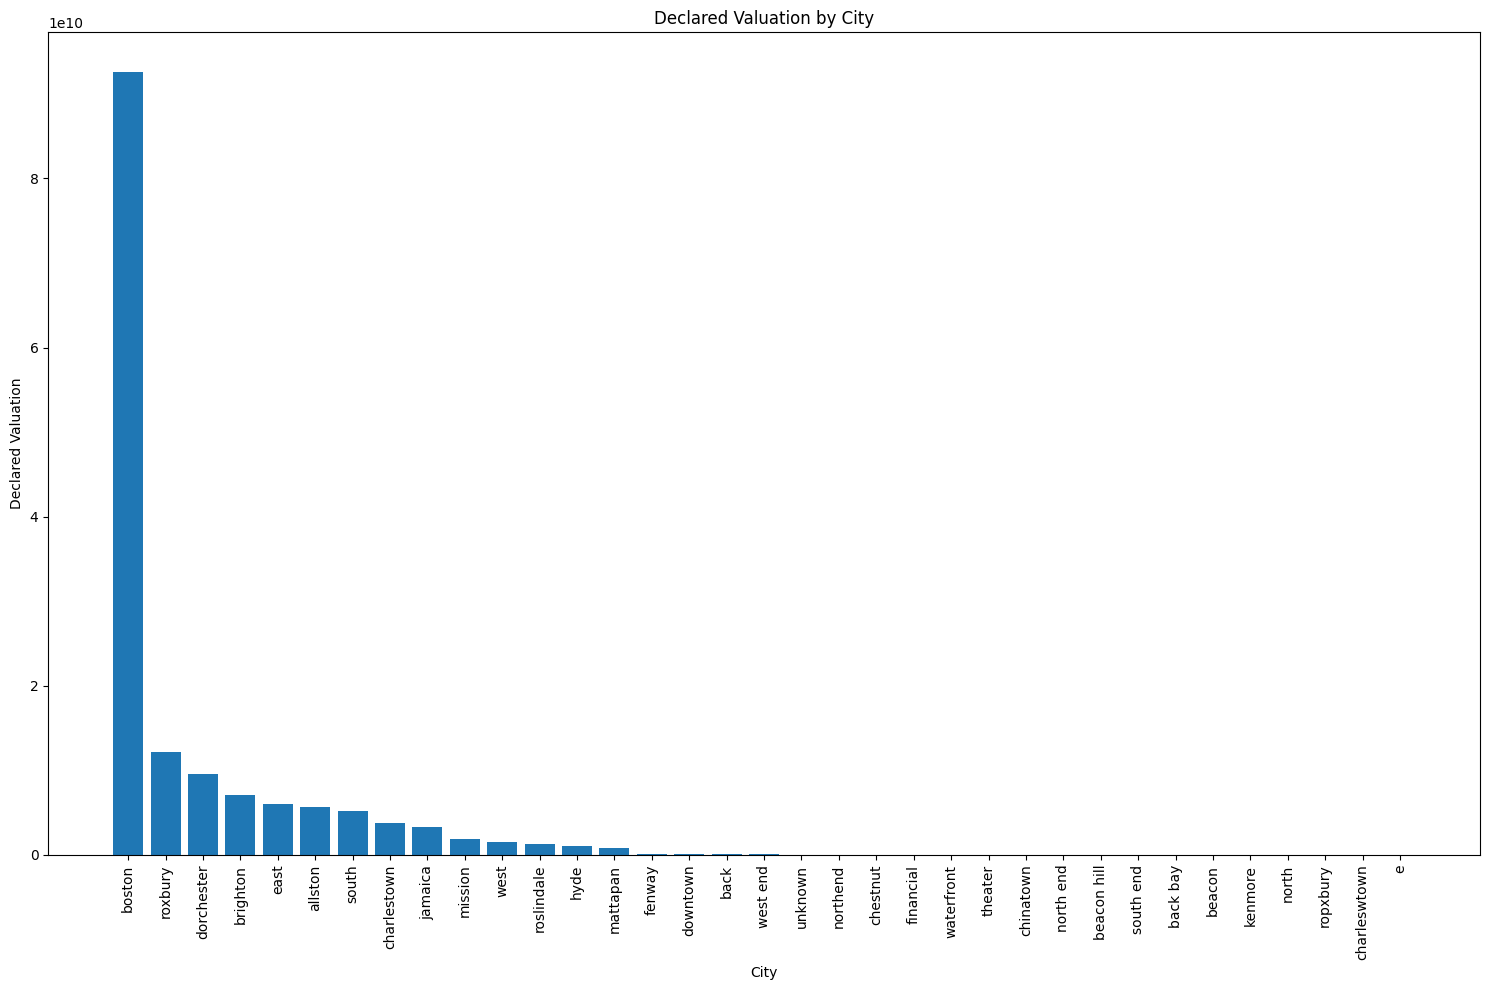

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('entire_surefire_undoubted_without_doubt_complete_definite_total_new.csv')

# Clean the data by dropping rows with missing city names
df = df.dropna(subset=['clean_city'])

# Convert 'declared_valuation' to numeric, just in case it's not
df['declared_valuation'] = pd.to_numeric(df['declared_valuation'], errors='coerce')

# Drop rows with NaN values that resulted from conversion errors
df = df.dropna(subset=['declared_valuation'])

# Sort the DataFrame based on 'declared_valuation' in descending order
df = df.sort_values(by='declared_valuation', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(15, 10))
plt.bar(df['clean_city'], df['declared_valuation'])
plt.xlabel('City')
plt.ylabel('Declared Valuation')
plt.title('Declared Valuation by City')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent clipping of x-axis labels
plt.show()


Show the greatest spending cities: this is more of a proof of concept to determine whether this appreciation is represented through overall spending (cities modernizing may be increasing in demand in therefore value).